## MobileNet_V3_small pretrained 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torchvision.models as models
from torch.optim import Adam
from torch.utils.data import WeightedRandomSampler

from sklearn.metrics import (precision_recall_fscore_support,
                             confusion_matrix)

from sklearn.metrics import classification_report

import os

from time import time

In [2]:
# set seed
torch.manual_seed(0)

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
#Define root directories with subdirectories
train_dir = os.getcwd() + "/data/train/"
val_dir = os.getcwd() + "/data/val/"
test_dir = os.getcwd() + "/data/test/"

In [5]:
# normalization values for pretrained resnet on Imagenet
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

batch_size = 30
test_batch_size = 30

In [6]:
# Transforms to prepare data and perform data augmentation
train_transforms = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

test_transforms = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

In [7]:
#instantiate datasets
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_data = torchvision.datasets.ImageFolder(root=val_dir, transform=test_transforms)
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [8]:
#check sizes and classes
print("Number of train samples: ", len(train_data))
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure
print("Number of validation samples: ", len(val_data))
print("Detected Classes are: ", val_data.class_to_idx)
print("Number of test samples: ", len(test_data))
print("Detected Classes are: ", test_data.class_to_idx)

Number of train samples:  6009
Detected Classes are:  {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of validation samples:  2003
Detected Classes are:  {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of test samples:  2003
Detected Classes are:  {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [9]:
#methods to get keys and values from dictionary of ImageFolder classes
def get_label(label_name):
    val = train_data.class_to_idx.get(label_name)
    return val

def get_label_name(val,d=train_data.class_to_idx):
    name = tuple([k for k, v in d.items() if v == val])[0]
    return name

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


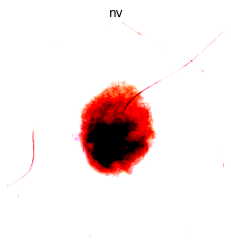

In [10]:
#check one image and label from imagefolder
plt.imshow(test_data[1000][0].permute(*torch.arange(test_data[1000][0].ndim - 1, -1, -1)))
plt.axis('off')
plt.title(get_label_name(test_data[1000][1]))
plt.show()

In [11]:
# Get counts of each class
def get_counts(data):
    """returns list of classes and counts"""
    labels = np.array(data.targets)
    (unique, counts) = np.unique(labels, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    return frequencies

# get dictionary of class names and counts
def get_distributions(data):
    counts = get_counts(data)
    class_distribution = {}
    for i in range(len(counts)):
        class_distribution.update({get_label_name(i): counts[i][1]})
    return class_distribution

In [12]:
train_counts = get_distributions(train_data)
val_counts = get_distributions(val_data)
test_counts = get_distributions(test_data)
#print(f'Counts of train data classses:\n{get_counts(train_data)}')
#print(f'Counts of test data classses:\n{get_counts(test_data)}')
print(f'Counts of train data classses:\n{train_counts}')
print(f'Counts of validation data classses:\n{val_counts}')
print(f'Counts of test data classses:\n{test_counts}')

Counts of train data classses:
{'akiec': 196, 'bcc': 309, 'bkl': 659, 'df': 69, 'mel': 668, 'nv': 4023, 'vasc': 85}
Counts of validation data classses:
{'akiec': 65, 'bcc': 102, 'bkl': 220, 'df': 23, 'mel': 223, 'nv': 1341, 'vasc': 29}
Counts of test data classses:
{'akiec': 66, 'bcc': 103, 'bkl': 220, 'df': 23, 'mel': 222, 'nv': 1341, 'vasc': 28}


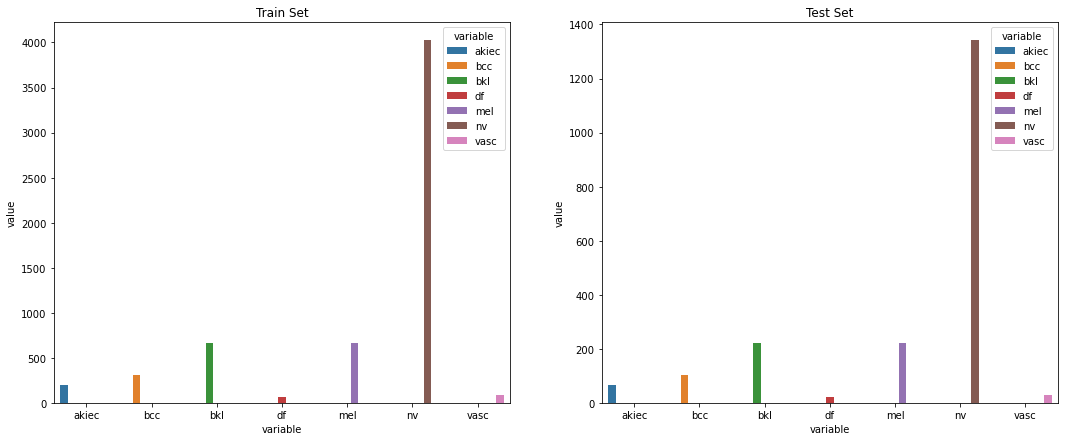

In [14]:
#plot class distributions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

sns.barplot(data = pd.DataFrame.from_dict([get_distributions(train_data)]).melt(), 
            x = "variable", y="value", 
            hue="variable",ax=axes[0]).set_title('Train Set')

# sns.barplot(data = pd.DataFrame.from_dict([get_distributions(val_data)]).melt(), 
#             x = "variable", y="value", 
#             hue="variable",ax=axes[0]).set_title('validation Set')

sns.barplot(data = pd.DataFrame.from_dict([get_distributions(test_data)]).melt(), 
            x = "variable", y="value", 
            hue="variable",ax=axes[1]).set_title('Test Set')

plt.show()

## Use resampling to account for class imbalance

In [15]:
# calculate weights for WeightedRandomSampler
# Get the class counts and calculate the weights/class by taking its reciprocal.
def get_RandomSamplerWeights(data):
    """returns tensor of weights for loss function"""
    data_counts=get_counts(data)
    weights = []
    for cat,count in data_counts:
        #weight = len(data)/(count*len(data_counts))
        weight = 1/count
        weights.append(weight)
    weights_tensor=torch.Tensor(weights)
    return(weights_tensor)

In [16]:
# get weights
RandomSamplerWeights = get_RandomSamplerWeights(train_data)
print(RandomSamplerWeights)

tensor([0.0051, 0.0032, 0.0015, 0.0145, 0.0015, 0.0002, 0.0118])


In [17]:
#get list of target classes
target_list = torch.tensor(train_data.targets)

#Assign the weight of each class to all the samples.
class_weights_all = RandomSamplerWeights[target_list]

In [18]:
#Pass the weight and number of samples to the WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [19]:
#load dataloader from ImageFolder
train_loader = data.DataLoader(train_data, batch_size=batch_size,sampler=weighted_sampler)
val_loader = data.DataLoader(val_data, batch_size=batch_size)
test_loader = data.DataLoader(test_data, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

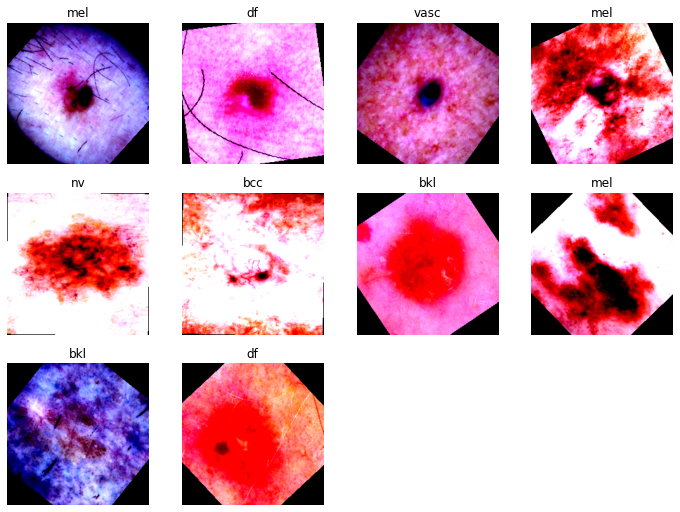

In [20]:
#check images for a single batch.
x, y = next(iter(train_loader))
#View each image
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)
for i in range (0,10):
    ax = fig.add_subplot(4,4,i+1)
    ax.axis('off')
    image = x[i]
    ax.set_title(get_label_name(y[i]))
    plt.imshow(image.permute(*torch.arange(image.ndim - 1, -1, -1)))
plt.axis('off')
plt.show()


In [21]:
# Load pretrained mobilenet_V3_small Model
model = models.mobilenet_v3_small(pretrained=True)

In [22]:
# Change the final classification head.
model.classifier[3] = nn.Linear(in_features=1024, out_features=7)

In [23]:
# calculate weights for loss function: wj=n_samples / (n_classes * n_samplesj)
def get_weights(data):
    """returns tensor of weights for loss function"""
    data_counts=get_counts(data)
    weights = []
    for cat,count in data_counts:
        weight = len(data)/(count*len(data_counts))
        weights.append(weight)
    weights_tensor=torch.Tensor(weights)
    return(weights_tensor)

In [24]:
#calculate weights for loss function to account for class imbalance
val_weights=get_weights(val_data)
val_weights.to(device)
print(f'Validation weights:\n{val_weights}') 

Validation weights:
tensor([ 4.4022,  2.8053,  1.3006, 12.4410,  1.2832,  0.2134,  9.8670])


In [25]:
# Create an object from the model
model = model.to(device)

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Weight validation loss function to account for class imbalance
val_criterion = nn.CrossEntropyLoss(weight=val_weights)
optimizer = optim.Adam(model.parameters())

In [28]:
time_0 = time()

# number of loops over the dataset
num_epochs = 10

best_loss=0.7113
best_model_epoch=10

train_losses, val_losses = [], []
train_accs, val_accs = [], []


for epoch in range(num_epochs):

    # Track epoch loss and accuracy
    epoch_loss, epoch_accuracy = 0, 0
    # Switch model to training (affects batch norm and dropout)
    model.train()
    # Iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        acc = ((outputs.argmax(dim=1) == labels).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print('Epoch: {}, train accuracy: {:.2f}%, train loss: {:.4f}'.format(epoch+1, epoch_accuracy*100, epoch_loss))
    train_losses.append(epoch_loss.item())
    train_accs.append(epoch_accuracy)
    

    ### Evaluation
    # Track epoch loss and accuracy
    epoch_valid_accuracy, epoch_valid_loss = 0, 0
    # Switch model to evaluation (affects batch norm and dropout)
    model.eval()
    # Disable gradients
    with torch.no_grad():
        # Iterate through batches
        for data, label in val_loader:
            # Move data to the used device
            data = data.to(device)
            label = label.to(device)
            # Forward pass
            valid_output = model(data)
            valid_loss = val_criterion(valid_output, label)
            # Compute metrics
            acc = ((valid_output.argmax(dim=1) == label).float().mean())
            epoch_valid_accuracy += acc/len(val_loader)
            epoch_valid_loss += valid_loss/len(val_loader) 
    print('Epoch: {}, val accuracy: {:.2f}%, val loss: {:.4f}'.format(epoch+1, epoch_valid_accuracy*100, epoch_valid_loss))
    val_losses.append(epoch_valid_loss.item())
    val_accs.append(epoch_valid_accuracy.item())
    
    #Save the best model
    if epoch_valid_loss<best_loss:
        torch.save(model.state_dict(),'MobileNet_best_checkpoint.model')
        best_loss=epoch_valid_loss
        best_model_epoch=epoch+1
        
print('Finished Training')

time_1 = time()

print("Training duration: {:.2f} minutes".format((time() - time_0)/60))
print(f"Best model identified at end of epoch {best_model_epoch}.")



Epoch: 1, train accuracy: 92.31%, train loss: 0.2145
Epoch: 1, val accuracy: 75.51%, val loss: 0.8394
Epoch: 2, train accuracy: 93.08%, train loss: 0.1976
Epoch: 2, val accuracy: 62.61%, val loss: 1.2257
Epoch: 3, train accuracy: 91.04%, train loss: 0.2397
Epoch: 3, val accuracy: 73.69%, val loss: 0.9927
Epoch: 4, train accuracy: 92.75%, train loss: 0.2048
Epoch: 4, val accuracy: 79.27%, val loss: 0.6703
Epoch: 5, train accuracy: 93.88%, train loss: 0.1782
Epoch: 5, val accuracy: 79.92%, val loss: 0.6628
Epoch: 6, train accuracy: 92.54%, train loss: 0.1983
Epoch: 6, val accuracy: 77.38%, val loss: 0.7095
Epoch: 7, train accuracy: 94.17%, train loss: 0.1601
Epoch: 7, val accuracy: 74.19%, val loss: 0.8936
Epoch: 8, train accuracy: 94.34%, train loss: 0.1585
Epoch: 8, val accuracy: 73.76%, val loss: 0.8974
Epoch: 9, train accuracy: 94.05%, train loss: 0.1676
Epoch: 9, val accuracy: 77.33%, val loss: 0.7813
Epoch: 10, train accuracy: 94.70%, train loss: 0.1519
Epoch: 10, val accuracy: 78.

In [27]:
train_losses_0 =train_losses
val_losses_0 = val_losses

In [29]:
val_losses_0

[0.9249674677848816,
 0.8871394395828247,
 0.9312164783477783,
 0.8012580871582031,
 0.808764636516571,
 0.7903377413749695,
 0.799243152141571,
 0.823413074016571,
 1.0415904521942139,
 0.7113099098205566]

In [30]:
val_losses

[0.8393726348876953,
 1.2257487773895264,
 0.9927464723587036,
 0.6703383922576904,
 0.6628168225288391,
 0.7095370292663574,
 0.8936108350753784,
 0.8974045515060425,
 0.7812517881393433,
 0.796664834022522]

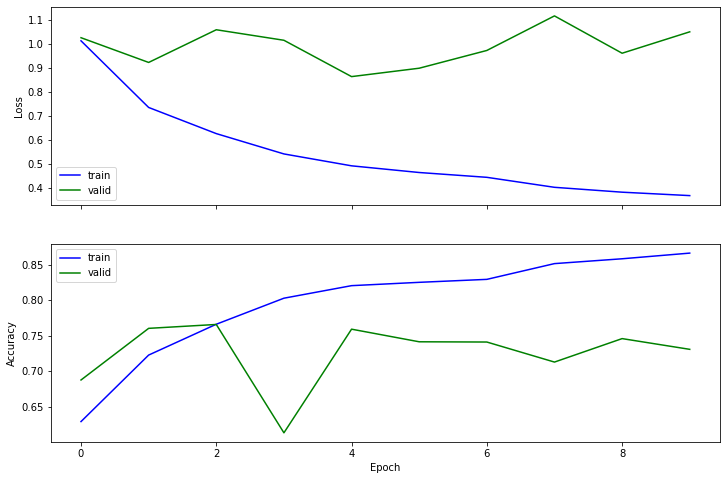

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
ax1.plot(train_losses, color='b', label='train')
ax1.plot(val_losses, color='g', label='valid')
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, color='b', label='train')
ax2.plot(val_accs, color='g', label='valid')
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()

In [37]:
#Get labels and predictions for test data

#Load best model as identified in training/validation loop
model.load_state_dict(torch.load('MobileNet_best_checkpoint_1.model'))
model.eval()

y_pred_np,y_true_np = [],[]
# Disable gradients
with torch.no_grad():
# Iterate through batches
    for data, label in test_loader:
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        output = model(data)
        # get predictions
        predictions = output.argmax(dim=1)
        labels = label
        y_pred_np = np.append(y_pred_np,predictions.numpy())
        y_true_np = np.append(y_true_np,labels.numpy())      

In [38]:
# Get overall and class accuracies
test_samples = len(test_data)
n_correct = 0
n_class_correct = [0 for i in range(7)]
classes =list(train_data.class_to_idx)
for i in range(test_samples):
    label = y_true_np[i].astype(int)
    pred = y_pred_np[i].astype(int)
    if (label == pred):
        n_class_correct[label] += 1
        n_correct += 1

acc = 100.0 * n_correct / test_samples
print(f'Accuracy of the network: {acc} %')

for i in range(7):
    acc = 100.0 * n_class_correct[i] / np.count_nonzero(y_true_np == i)
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 81.7773339990015 %
Accuracy of akiec: 45.45454545454545 %
Accuracy of bcc: 57.28155339805825 %
Accuracy of bkl: 69.0909090909091 %
Accuracy of df: 60.869565217391305 %
Accuracy of mel: 68.01801801801801 %
Accuracy of nv: 90.0820283370619 %
Accuracy of vasc: 85.71428571428571 %


In [39]:
confusion_matrix(y_true_np, y_pred_np)

array([[  30,    2,   18,    1,    5,   10,    0],
       [   2,   59,   12,    0,    7,   23,    0],
       [   1,    1,  152,    0,   25,   40,    1],
       [   0,    2,    4,   14,    2,    1,    0],
       [   1,    0,   15,    0,  151,   53,    2],
       [   0,    1,   29,    0,   97, 1208,    6],
       [   0,    0,    0,    0,    1,    3,   24]])

<AxesSubplot:>

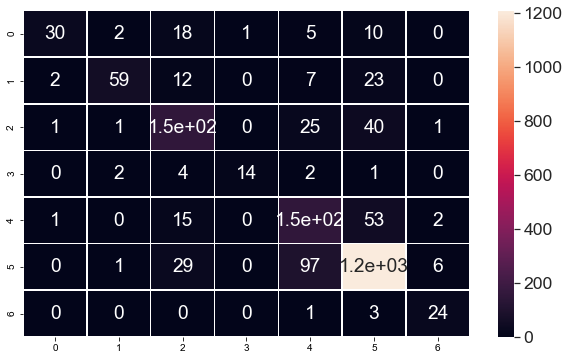

In [42]:
#Print confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

fig, ax = plt.subplots(figsize=(10,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [40]:
# Generate a classification report
report = classification_report(y_true_np, y_pred_np, target_names=classes)
print(report)

              precision    recall  f1-score   support

       akiec       0.88      0.45      0.60        66
         bcc       0.91      0.57      0.70       103
         bkl       0.66      0.69      0.68       220
          df       0.93      0.61      0.74        23
         mel       0.52      0.68      0.59       222
          nv       0.90      0.90      0.90      1341
        vasc       0.73      0.86      0.79        28

    accuracy                           0.82      2003
   macro avg       0.79      0.68      0.71      2003
weighted avg       0.83      0.82      0.82      2003



Text(0, 0.5, 'Fraction of incorrect predictions')

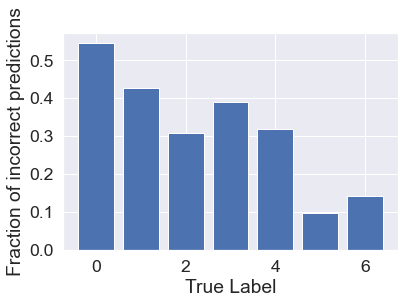

In [43]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')